In [61]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from escnn import nn, group, gspaces
from matplotlib import pyplot as plt

from models.core.point_convolution import ImplicitPointConv
from utils.utils import get_elu
from models.core.implicit_kernel import ImplicitKernelSON

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Azymuthal-rotation equivariant model

Let's implement a convolutional layer that is equivariant under rotations around the z-axis and acts on field on $\mathbb{R}^3$.

Since we work in escnn, we need to specify the group space, and indicate which subgroup of O(3) we work with.

In [62]:
gspace = gspaces.rot2dOnR3() # SO(2) on R^3
subgroup_id = gspace._sg_id[:-1] # indicator for the subgroup SO(2) \in O(3)

We assume that our input is 3 vector fields and 2 scalar fields, and the output is 1 vector field.

In [63]:
# restrict the standard representation of O(3) to SO(2)
std_repr = group.o3_group().standard_representation().restrict(subgroup_id) 
triv_repr = gspace.trivial_repr 

in_repr = 3*[std_repr] + 2*[triv_repr]
out_repr = 1*[std_repr] + 1*[triv_repr]

# set field type of the input and output
in_type = gspace.type(*in_repr)
out_type = gspace.type(*out_repr)

Implicit point convolution takes as input node and edge features of a geometric graph.

Hence, we have to specify the representation of edge features.

Let us assume that we have 2 edge features,  one of which is a scalar field and one is a vector field.

In [64]:
edge_repr = 1*[gspaces.no_base_space(group.o3_group()).trivial_repr] + 1*[group.o3_group().standard_representation()]

[OPTIONAL] For better initialization, we can give an approximate feature distribution to the kernel.

First element is for relative positions, second is for additional edge features specified above.

Assuming that edge features follow a normal distribution with mean 0 and std 0.5, we have:

In [65]:
edge_distr = [None, torch.distributions.Normal(torch.zeros(4), 0.5*torch.ones(4))]

We also need to specify the order of harmonic polynomials we use in the implicit kernel.

Let's use polynomials of order 2.

In [66]:
hp_order = 2

Let us now build a Steerable CNN model with 3 convolutional layers and QuotientFourier non-linearity.

It is important to say that implicit kernels only support uniform representations.

It means that the input and output representations of the model must be the copies of the same representation.

This is not a limitatiom per se, since we can always map a non-uniform representation to a uniform one, e.g. using a Projector module.

Last, we need to specify parameters of the MLP with which we parametrize steerable filters.

In [67]:
mlp_params = dict(n_layers=3, 
                  n_channels=8, 
                  act_fn='elu', 
                  use_tp=False)

In [68]:
class Projector(nn.EquivariantModule):
    def __init__(self, in_type: nn.FieldType, out_type: nn.FieldType):
        super().__init__()
        G = in_type.gspace.fibergroup
        gspace = gspaces.no_base_space(G)
        self.in_type = in_type
        self.hid_type1 = gspace.type(*in_type.representations)
        self.hid_type2 = gspace.type(*out_type.representations)
        self.linear = nn.Linear(self.hid_type1, self.hid_type2) 
        self.out_type = out_type
    
    def forward(self, x):
        x, coords = x.tensor, x.coords
        x = self.hid_type1(x)
        x = self.linear(x)
        x = nn.GeometricTensor(x.tensor, self.out_type, coords)
        return x
    
    def evaluate_output_shape(self):
        pass

In [69]:
# We use 16 hidden channels for all layers and band-limit representations up to frequency L=1
hidden_channels = 3
L = 1

activation = get_elu(gspace = in_type.gspace, L = L, channels = hidden_channels)

# in Steerable CNNs, hidden channels are determined by the activation function.
hidden_type = activation.out_type
# print(f"hidden type: {hidden_type} with size {hidden_type.size}\nL = {L}, hidden channels = {hidden_channels}")
print(f"{hidden_channels} hidden fields with representation: {hidden_type.representations[0]}")

proj_in = Projector(in_type, hidden_type)

layer1 = ImplicitPointConv(
    in_type=hidden_type,
    out_type=hidden_type,
    edge_repr=edge_repr,
    hp_order=hp_order,
    edge_distr=edge_distr,
    **mlp_params)

x = x_org = nn.GeometricTensor(torch.randn(10,hidden_type.size), layer1.in_type, torch.randn(10,3))

edge_index = torch.randint(0, 10, (2, 20))
edge_delta = torch.randn(20,3)
edge_attr = torch.randn(20,4)

outa_orgimpl = layer1(x=x, edge_index=edge_index, edge_delta=edge_delta, edge_attr=edge_attr, idx_downsampled=None)

3 hidden fields with representation: SO(2)|[regular_[(0,)|(1,)]]:3


# Test equivariance

We need to specify the type of edge features for the layer (it is done automatically inside the implicit kernel)

In [70]:
std_type = gspaces.no_base_space(group.o3_group()).type(*[group.o3_group().standard_representation()]).restrict(subgroup_id) 
edge_type = gspaces.no_base_space(group.o3_group()).type(*edge_repr).restrict(subgroup_id) 

In [71]:
x = x_org = nn.GeometricTensor(torch.randn(10,hidden_type.size), layer1.in_type, torch.randn(10,3))

edge_index = torch.randint(0, 10, (2, 20))
edge_delta = torch.randn(20,3)
edge_attr = torch.randn(20,4)


el = list(gspace.testing_elements)[10]

In [72]:
def aggregate(src, index, dim_size, dim):
    """
    From 
    - /Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/torch_geometric/nn/conv/message_passing.py
    - /Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/torch_geometric/nn/resolver.py
    - /Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/torch_geometric/nn/aggr/base.py
    - /Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/torch_geometric/nn/aggr/basic.py
    - /Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/torch_geometric/utils/scatter.py
    """

    def broadcast(src, ref, dim: int):
        size = ((1, ) * dim) + (-1, ) + ((1, ) * (ref.dim() - dim - 1))
        return src.view(size).expand_as(ref)
    
    size = src.size()[:dim] + (dim_size, ) + src.size()[dim + 1:]

    count = src.new_zeros(dim_size)
    count.scatter_add_(0, index, src.new_ones(src.size(dim)))
    count = count.clamp(min=1)

    index = broadcast(index, src, dim)
    out = src.new_zeros(size).scatter_add_(dim, index, src)

    out = out / broadcast(count, out, dim)
    return out


In [73]:
in_repr, out_repr = hidden_type, hidden_type

k = implicit_kernel = ImplicitKernelSON(
    in_repr=in_repr, 
    out_repr=out_repr,
    edge_repr=edge_repr, 
    hp_order=hp_order,
    **mlp_params
    )

In [74]:
mlp_params

{'n_layers': 3, 'n_channels': 8, 'act_fn': 'elu', 'use_tp': False}

In [83]:


## Tranform a
x_a = x_org



x = k.transform_coords(edge_delta)
x = nn.GeometricTensor(torch.cat([x.tensor, edge_attr], 1), k.mlp.in_type)
x = k.mlp(x)
x = k.transform_mlp(x, edge_delta, init=True)
c_in, c_out  = len(in_repr), len(out_repr)
delta_in, delta_out = int(in_repr.size / len(in_repr)), int(out_repr.size / len(out_repr))
filter = x.reshape((-1, c_out * delta_out, c_in * delta_in)) # shape: [n_edges, c_out, c_in]

x_j = torch.stack([x_a.tensor[i] for i in edge_index[0]]) # shape: [n_edges, c_in]
outa_einsum = torch.einsum('noi,ni->no', filter, x_j) # shape: [2*n_edges, c_out]
outa = aggregate(src=outa_einsum, index=edge_index[1], dim_size=10, dim=0) # shape: [n_edges, c_out]

outa = nn.GeometricTensor(outa, type = hidden_type, coords=x_a.coords) 

outa = outa.transform_fibers(el)
outa = outa.tensor.detach()



### Tranform b
x_b = x_transformed = x_org.transform_fibers(el)
edge_delta_transformed = nn.GeometricTensor(edge_delta, std_type).transform_fibers(el).tensor
edge_attr_transformed = nn.GeometricTensor(edge_attr, edge_type).transform_fibers(el).tensor

x = k.transform_coords(edge_delta_transformed)
x0 = x = nn.GeometricTensor(torch.cat([x.tensor, edge_attr_transformed], 1), k.mlp.in_type)
x1 = x = k.mlp(x)
x_tranf = x = k.transform_mlp(x, edge_delta_transformed, init=True)
filter_tranformed = x.reshape((-1, c_out * delta_out, c_in * delta_in)) # shape: [n_edges, c_out, c_in]

x_j = torch.stack([x_b.tensor[i] for i in edge_index[0]]) # shape: [n_edges, c_in]
outb_einsum = torch.einsum('noi,ni->no', filter_tranformed, x_j) # shape: [2*n_edges, c_out]
outb = aggregate(src=outb_einsum, index=edge_index[1], dim_size=10, dim=0) # shape: [n_edges, c_out]

outb = nn.GeometricTensor(outb, type = hidden_type, coords=x_b.coords)
outb = outb.tensor.detach().numpy()

diff = np.abs(outa - outb)

print(f"max {diff.max():.2e}, mean {diff.mean():.2e}, std {diff.std():.2e}")

max 2.02e-03, mean 1.96e-04, std 3.06e-04


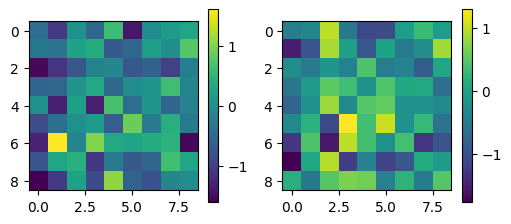

In [84]:
plots = [filter_tranformed[0].detach().numpy(), filter[0].detach().numpy()]

n_plots = len(plots)
fig, axs = plt.subplots(1,n_plots, figsize = (3*n_plots,5))
for ax, p in zip(axs, plots):
    im = ax.imshow(p)
    fig.colorbar(im, ax=ax, shrink=0.5)
plt.show()

In [85]:
x0.shape, x1.shape, x_tranf.shape, filter_tranformed.shape, outb_einsum.shape, outb.shape

(torch.Size([20, 13]),
 torch.Size([20, 81]),
 torch.Size([20, 3, 3, 3, 3]),
 torch.Size([20, 9, 9]),
 torch.Size([20, 9]),
 (10, 9))

In [77]:
edge_delta.shape, edge_attr.shape, filter_tranformed.shape, outb_einsum.shape

(torch.Size([20, 3]),
 torch.Size([20, 4]),
 torch.Size([20, 9, 9]),
 torch.Size([20, 9]))

In [78]:
x = x_org

outa_orgimpl = layer1(x=x, edge_index=edge_index, edge_delta=edge_delta, edge_attr=edge_attr, idx_downsampled=None).transform_fibers(el).tensor.detach().numpy()

edge_delta_ = nn.GeometricTensor(edge_delta, std_type)
edge_attr_ = nn.GeometricTensor(edge_attr, edge_type)
outb_orgimpl = layer1(x.transform_fibers(el), 
                edge_index=edge_index, 
                edge_delta=edge_delta_.transform_fibers(el).tensor, 
                edge_attr=edge_attr_.transform_fibers(el).tensor, 
                idx_downsampled=None).tensor.detach().numpy()

diff = np.abs(outa_orgimpl - outb_orgimpl)

print(f"max {diff.max():.2e}, mean {diff.mean():.2e}, std {diff.std():.2e}")


max 1.83e-03, mean 2.42e-04, std 3.26e-04


### Compare x_j and x

In [79]:
assert False

AssertionError: 

In [ ]:
x_j = torch.stack([x_org.tensor[i] for i in edge_index[0]])
assert (x_j == torch.load("x_j.pt")).all()
x_j.shape

In [ ]:
x_cat = torch.cat(x)
x_cat.shape, outa0.shape, edge_index[1].unsqueeze(1).shape

`# self.reduce(src = x = outa0, index = edge_index[1], ptr=None, dim_size = 10, dim = -2, reduce = 'mean')`

In [ ]:
def broadcast(src, ref, dim: int):
    size = ((1, ) * dim) + (-1, ) + ((1, ) * (ref.dim() - dim - 1))
    return src.view(size).expand_as(ref)

In [ ]:
src = outa0
index = edge_index[1]
dim_size = 10
dim = 0 #-2

size = src.size()[:dim] + (dim_size, ) + src.size()[dim + 1:]

count = src.new_zeros(dim_size)
count.scatter_add_(0, index, src.new_ones(src.size(dim)))
count = count.clamp(min=1)

index = broadcast(index, src, dim)
out = src.new_zeros(size).scatter_add_(dim, index, src)

outa0 = out / broadcast(count, out, dim)


In [ ]:
outa02 = np.zeros_like(outa)

for i in edge_index[1]:
    sel_idxs = torch.where(edge_index[1] == i)
    outa0_sels = outa0[sel_idxs]

    # outa02[i] = torch.max(outa0[sel_idxs], axis = 0).values
    outa02[i] += torch.mean(outa0[sel_idxs], axis = 0).numpy()



# plots = [x_cat, x_j, x_j_recon]
plots = [outa0, outa, outa02, x_agg]

n_plots = len(plots)
fig, axs = plt.subplots(1,n_plots, figsize = (3*n_plots,5))
for ax, p in zip(axs, plots):
    absmax = np.abs(p).max()
    print(absmax)
    ax.imshow(p, vmin = -absmax, vmax = absmax)
plt.show()

In [ ]:
outa.sum()

In [ ]:
for p in plots:
    print(p.min(), p.max())

In [ ]:
outa02 = np.zeros_like(outa)

for i, outa02_i in enumerate(outa02):
    pass
    # outa02_i[edge_index[0][i]] += outa[i]



In [ ]:
outa02 = np.zeros_like(outa)

for i in edge_index[1]:
    # Sum
    outa02[i] += outa0[i].detach().numpy()

    # Mean
    sel_idxs = torch.where(edge_index[1] == i)
    outa02[i] = torch.mean(outa0[sel_idxs], axis = 0).detach().numpy()



In [ ]:
outa0.shape, x_j.shape, edge_index.shape